In [1]:
%matplotlib widget

In [2]:
import jax.numpy as jnp
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from picasso import cic
from halotools.empirical_models import NFWPhaseSpace
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(70.0, 0.3)

In [3]:
def get_nfw_particles(num_pts, M_vir, c_vir, z, cosmo):
    """
    Generates random particle positions following a Navarro-Frenk-White
    (NFW) density profile.

    Parameters
    ----------
    num_pts : int
        Number of particles to be generated
    M_vir : float
        Halo virial mass [h-1 Msun]
    c_vir : float
        Halo virial concentration
    z : float
        Halo redshift
    cosmo : astropy.cosmology.Cosmology
        Cosmology to be used

    Returns
    -------
    halotools.empirical_models.NFWProfile
        halotools profile object used for the sampling
    float
        Halo virial radius [h-1 Mpc]
    dict
        Particles (see Notes)

    Notes
    -----
    The particles are returned as a dict, with keys:
        * (x, y, z): 3D positions, centered on (0, 0, 0) [h-1 Mpc]
        * r: distance from center [h-1 Mpc]
        * mass: particle mass [h-1 Msun]
            (This is just M_vir / num_pts)
        * (vx, vy, vz): these are here because gigos needs them to
            work. The values in there mean nothing.
    """

    nfw = NFWPhaseSpace(cosmology=cosmo, redshift=z, mdef="vir")
    R_vir = nfw.halo_mass_to_halo_radius(M_vir)  # h-1 Mpc
    m_part = M_vir / num_pts  # h-1 Msun

    p = nfw.mc_generate_nfw_phase_space_points(
        Ngals=int(num_pts), conc=c_vir, mass=M_vir
    )
    parts = {c: np.array(p[c]) for c in p.colnames}

    parts["mass"] = m_part * np.ones(num_pts)
    parts["r"] = parts.pop("radial_position")

    return nfw, R_vir, parts


In [4]:
num_pts = int(1e5)
M_vir = 1e15  # h-1 Msun
c_vir = 10.0
z = 0

np.random.seed(1811)
nfw, R_vir, parts = get_nfw_particles(num_pts, M_vir, c_vir, z, cosmo)

In [5]:
xyz = np.array([parts[_] for _ in "xyz"]).T
box_size = 3.0 * R_vir
n_cells = 71
cell_size = box_size / n_cells
m_grid = cic.cic_3d_nojax(xyz, np.zeros(3), box_size, n_cells, weights=parts["mass"], verbose=False)
rho_grid = m_grid / (cell_size ** 3)

In [6]:
xyz_grid = np.array(
    np.meshgrid(
        np.linspace(-box_size / 2, box_size / 2, n_cells),
        np.linspace(-box_size / 2, box_size / 2, n_cells),
        np.linspace(-box_size / 2, box_size / 2, n_cells),
    )
)
r_grid = np.sqrt(np.sum(xyz_grid**2, axis=0))
nfw_rho_grid = nfw.mass_density(r_grid, M_vir, c_vir)

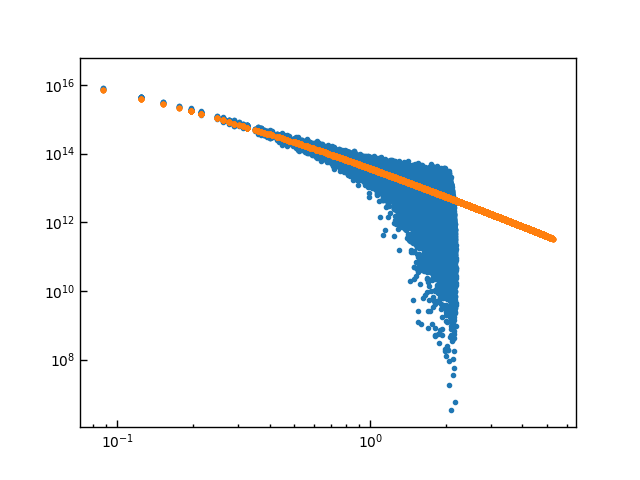

In [7]:
plt.close("all")
fig, ax = plt.subplots()
ax.loglog(r_grid.flatten(), rho_grid.flatten(), ".")
ax.loglog(r_grid.flatten(), nfw_rho_grid.flatten(), ".")

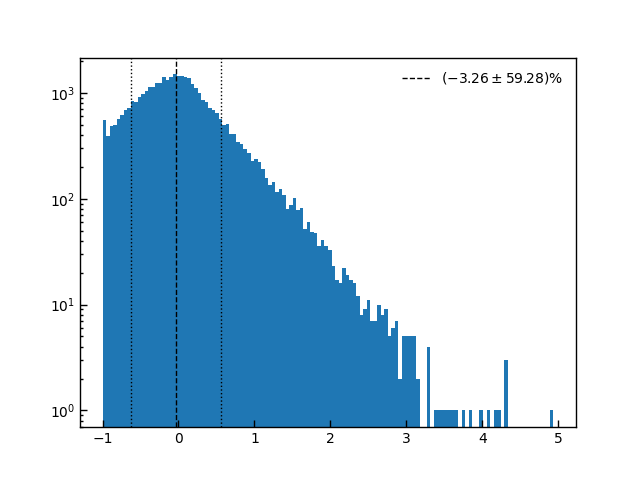

In [9]:
fig, ax = plt.subplots()
rel_diff = (rho_grid / nfw_rho_grid) - 1
ok = (r_grid < 0.9 * R_vir)
ax.hist(rel_diff[ok], bins=128, log=True)
mu, sigma = np.median(rel_diff[ok]), np.std(rel_diff[ok])
for i in [+1, -1]:
    ax.axvline(mu + i * sigma, 0, 1, color="k", ls=":")
ax.axvline(mu, 0, 1, color="k", ls="--", label=f"$({100*mu:.2f} \\pm {100*sigma:.2f}) \\%$")
ax.legend()